# Sesión 7: Pruebas A/B y Procesamiento de Lenguaje Natural

Las Pruebas A/B nos permiten conocer si algún cambio que sea realizó tuvo un mejor desempeño o en realidad fue por puro azar. por ejemplo en marketing si una estrategia está generando mayores ventas o en realidad ese incremento de ventas fue por suerte y no tiene relaicón con el cambio en la campaña de marketing.

Se tendrá entonces un grupo de control y otro esperimental, un ejemplo en medicina es que al grupo de control se le da el placebo y al experimental se le da el medicamento, y se observa si el medicamento funciona. 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Cargamos datos a utilizar
df = pd.read_csv("/content/drive/MyDrive/datasets_BEDU/Remoto ab_test-sales_pipeline.csv")
df.head()

# Donde A es la nueva campaña publicitaria y B la campaña de siempre
# Conversión significa que el cliente compró el porducto y no conversion en caso contrario

,test,conversion,no conversion
0,B,0,1
1,A,0,1
2,A,0,1
3,A,0,1
4,A,0,1


In [5]:
#Veamos cuantos se vendieron de cada publicidad
total_count = df.groupby('test')[['conversion', 'no conversion']].sum()
total_count

,conversion,no conversion
test,,
A,198,23541
B,184,22404


In [8]:
# Veamos el porcentaje del total
total_count['sucess_rate'] = total_count['conversion']/(total_count['conversion'] + total_count['no conversion'])
total_count

,conversion,no conversion,sucess_rate
test,,,
A,198,23541,0.008341
B,184,22404,0.008146


In [9]:
#Veamos ahora la diferencia en proporcion de cada campaña
diferencia_en_proporcion = 1-(total_count.loc['B']['sucess_rate']/total_count.loc['A']['sucess_rate'])
print(f"El test A fue {diferencia_en_proporcion*100:.2f}% mejor que B para generar ventas")

El test A fue 2.34% mejor que B para generar ventas


Entonces, aún debemos verificar si el porcentaje de 2.34% fue como resultado de la nueva campaña, o en realidad fue por azar?

In [11]:
value_counts = df['test'].value_counts()
value_counts

A    23739
B    22588
Name: test, dtype: int64

Lo que se hace es crear nuevos grupos de A y B, tomando aleatoriamente los elementos tanto de conversion (si compraron) como los que no.

In [12]:
# Prueba de Permutacion
# Guardamos en diferentes listas cuantos convergen en a y cuantos no convergen en a igual para b

conv_a = []
no_conv_a = []
conv_b = []
no_conv_b =[]

# Indico una muestra aleatoria tomados de A y B y los meto en un nuevo grupo A, y sumo cuantos fueron para conversion (sin comrparon) y no conversion
# Lo hacemos mil veces.
for i in range(1000):
  a = df.sample(value_counts.loc['A'], replace = False)
  conv_a.append(a['conversion'].sum())
  no_conv_a.append(a['no conversion'].sum())

# Ahora el grupo B será todos los elementos que no tomé para A, es decir todos los qu eno están en A los meto en B y nueva,ente saco cuantos son de conversion y cuantos no
  b = df.loc[~df.index.isin(a.index)]
  conv_b.append(b['conversion'].sum())
  no_conv_b.append(b['no conversion'].sum())


In [13]:
# Tabulo los resutados obtenids de los nuevos grupos
results = pd.DataFrame({
    'conv_a': conv_a,
    'no_conv_a': no_conv_a,
    'conv_b': conv_b,
    'no_conv_b': no_conv_b
})

results

,conv_a,no_conv_a,conv_b,no_conv_b
0,195,23544,187,22401
1,200,23539,182,22406
2,200,23539,182,22406
3,190,23549,192,22396
4,185,23554,197,22391
...,...,...,...,...
995,192,23547,190,22398
996,198,23541,184,22404
997,203,23536,179,22409
998,207,23532,175,22413


In [14]:
# La proporcion para cada reultado conversion y no conversion y ademas la diferencia
results['a_conv_rate'] = results['conv_a'] /(results['conv_a'] + results['no_conv_a'])
results['b_conv_rate'] = results['conv_b'] /(results['conv_b'] + results['no_conv_b'])
results['diff'] = 1 - (results['b_conv_rate'] / results['a_conv_rate'])

results


,conv_a,no_conv_a,conv_b,no_conv_b,a_conv_rate,b_conv_rate,diff
0,195,23544,187,22401,0.008214,0.008279,-0.007840
1,200,23539,182,22406,0.008425,0.008057,0.043630
2,200,23539,182,22406,0.008425,0.008057,0.043630
3,190,23549,192,22396,0.008004,0.008500,-0.062019
4,185,23554,197,22391,0.007793,0.008721,-0.119126
...,...,...,...,...,...,...,...
995,192,23547,190,22398,0.008088,0.008412,-0.040009
996,198,23541,184,22404,0.008341,0.008146,0.023354
997,203,23536,179,22409,0.008551,0.007925,0.073295
998,207,23532,175,22413,0.008720,0.007747,0.111510


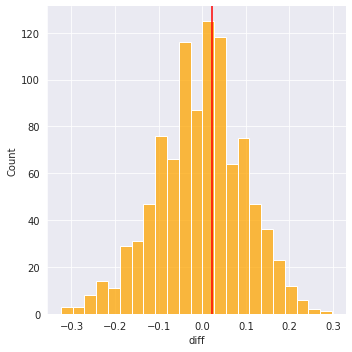

In [17]:
# graficamos la diferencia de los resutados para ver si la distribucion converge a una normal
# Y colocamos una linea de la diferencia en proporcion de los grupos originales
sns.set_style('darkgrid')
sns.displot(results['diff'], color = 'orange')
plt.axvline(diferencia_en_proporcion, color = 'r');

Notemos que la diferencia debería estar en los extremos de la normalidad, para poder decir que realmente la diferencia está funcionando, ya que como cae dentro de la distribución dire las nuevas compras no fueron por la nueva campaña publicitaria sono de debió al azar. No es suficientemente marcado el numero de ventas para decir que la campaña funciona.

No hay mejoras en la nueva campaña.

In [18]:
# Sacando el valor P notemos que claramente no tiene significancia estadística
(results['diff'] >= diferencia_en_proporcion).sum() / results.shape[0]

0.428

# Intro al Procesamiento de Lenguaje Natural
### Expresiones regulares usando Regex
Busqueda de patrones en texto

In [19]:
import pandas as pd
import re

In [23]:
# Cargamos datos
df = pd.read_json("/content/drive/MyDrive/datasets_BEDU/Remoto new_york_times_bestsellers-clean.json")
df.head()

,amazon_product_url,author,description,publisher,title,oid,bestsellers_date.numberLong,published_date.numberLong,rank.numberInt,rank_last_week.numberInt,weeks_on_list.numberInt,price.numberDouble
0,http://www.amazon.com/The-Host-Novel-Stephenie...,Stephenie Meyer,Aliens have taken control of the minds and bod...,"Little, Brown",THE HOST,5b4aa4ead3089013507db18c,1211587200000,1212883200000,2,1,3,25.99
1,http://www.amazon.com/Love-Youre-With-Emily-Gi...,Emily Giffin,A woman's happy marriage is shaken when she en...,St. Martin's,LOVE THE ONE YOU'RE WITH,5b4aa4ead3089013507db18d,1211587200000,1212883200000,3,2,2,24.95
2,http://www.amazon.com/The-Front-Garano-Patrici...,Patricia Cornwell,A Massachusetts state investigator and his tea...,Putnam,THE FRONT,5b4aa4ead3089013507db18e,1211587200000,1212883200000,4,0,1,22.95
3,http://www.amazon.com/Snuff-Chuck-Palahniuk/dp...,Chuck Palahniuk,An aging porn queens aims to cap her career by...,Doubleday,SNUFF,5b4aa4ead3089013507db18f,1211587200000,1212883200000,5,0,1,24.95
4,http://www.amazon.com/Sundays-at-Tiffanys-Jame...,James Patterson and Gabrielle Charbonnet,A woman finds an unexpected love,"Little, Brown",SUNDAYS AT TIFFANY’S,5b4aa4ead3089013507db190,1211587200000,1212883200000,6,3,4,24.99


In [26]:
# Queremos unicamente las descripciones entonces filtramo
new_df = df.groupby("title")["description"].max()
new_df

title
10TH ANNIVERSARY            Detective Lindsay Boxer and the Women’s Murder...
11TH HOUR                   Detective Lindsay Boxer and the Women’s Murder...
1225 CHRISTMAS TREE LANE    Puppies and an ex-husband loom large in the la...
1356                        In the fourth book of the Grail Quest series, ...
1Q84                        In 1980s Tokyo, a woman who punishes perpetrat...
                                                  ...                        
Z                           A novel based on the lives of Zelda and F. Sco...
ZERO DAY                       A military investigator uncovers a conspiracy.
ZERO HISTORY                Several characters from “Spook Country” return...
ZONE ONE                      Fighting zombies in post-apocalyptic Manhattan.
ZOO                         A young biologist warns world leaders about th...
Name: description, Length: 754, dtype: object

In [27]:
# Notemos que ahora tenemos una serie que le podemos aplicar metodos de strings
# Queremos todas las filas cuya descripcion contiene woman
new_df[new_df.str.contains('woman', case = False)] # El case indica 'case sensitive'

title
1Q84                      In 1980s Tokyo, a woman who punishes perpetrat...
A CEDAR COVE CHRISTMAS    A pregnant woman shows up in Cedar Cove on Chr...
A CHANGE IN ALTITUDE      A young woman’s life is transformed by a mount...
A TURN IN THE ROAD        A middle-age woman takes a cross-country road ...
AN OBJECT OF BEAUTY       A young, beautiful and ambitious woman ruthles...
                                                ...                        
THIS BODY OF DEATH        Detective Thomas Lynley becomes involved when ...
THOSE IN PERIL            A private security agent battles pirates who h...
WHAT DOESN'T KILL YOU     A Hong Kong woman who works for the C.I.A. sea...
WHERE WE BELONG           A woman’s successful life is disrupted by the ...
WHILE MY SISTER SLEEPS    A woman makes discoveries about her sister and...
Name: description, Length: 74, dtype: object

In [28]:
#Ahora quiero buscar los que contienen número que van entre 0 y 9 
new_df[new_df.str.contains("[0:9]")]

title
1Q84                           In 1980s Tokyo, a woman who punishes perpetrat...
2030                           In 2030, the young resent the elderly for drai...
A LESSON IN SECRETS            In the summer of 1932, Maisie Dobbs’s first as...
A PERFECT BLOOD                The witch Rachel Morgan faces a human hate gro...
A RIVER IN THE SKY             In 1910, the Peabody-Emerson clan tries to hea...
                                                     ...                        
THE STORYTELLER                A New Hampshire baker finds herself in the mid...
THE STRIKER                    n 1902, the young detective Isaac Bell discove...
THE TWELVE TRIBES OF HATTIE    Fifty-some years in the life of an African-Ame...
THE WRECKER                    In 1907, a detective tracks a mysterious sabot...
WORST CASE                     A New York detective raising 10 children alone...
Name: description, Length: 72, dtype: object

In [38]:
# Uno o más números seguidos de una o más letras
new_df[new_df.str.contains("[1-9]+[a-z]+", case = False)]

title
A MEMORY OF LIGHT                           The 14th and final novel in the Wheel of Time ...
A MERCY                                     In 17th-­century America, a slave mother urges...
A MIGHTY FORTRESS                           Book 4 of the Safehold series, which translate...
ANGEL TIME                                  \nA contract killer goes back to 13th-century ...
BONES ARE FOREVER                           The forensic anthropologist Temperance Brennan...
BREAKING POINT                              The 13th novel featuring Joe Pickett, a Wyomin...
DAMAGE CONTROL                              An elderly couple’s suicide-by-accident in the...
DARK STORM                                  In the 23rd book in the Dark series, the Carpa...
DAYS OF GOLD                                In the 18th century, Edilean and a Scottish la...
FLIRT                                       Anita Blake, vampire hunter, and the males in ...
ISLAND BENEATH THE SEA                      The story 

In [41]:
# Queremos los que empiezan especificamente con un patron
new_df[new_df.str.contains("^After", case = False)]

title
DON’T BLINK                        After a gruesome murder in a New York steak ho...
FATAL ERROR                        After the murder of a cyber-sociopath, Ali Rey...
FOUNDERS                           After society collapses, America’s fate is in ...
RAPTURE                            After a man stumbles in front of the reporter ...
STANDING IN ANOTHER MAN'S GRAVE    After retiring from the Edinburgh police force...
THE DOG STARS                      After a flu pandemic kills most of the populat...
THE MAGICIANS                      After sorcery college, a young man lives the h...
WINTER GARDEN                      After their father’s death, two sisters must c...
Name: description, dtype: object

In [42]:
# Los que terminan con un patron, por ejemplo La palabra London. (notemos que estoy agregamdo el punto final al string)
new_df[new_df.str.contains("London.$", case = False)]

title
A DEVIL IS WAITING        Sean Dillon helps to foil a plot to assassinat...
A WALLFLOWER CHRISTMAS                     Matchmaking in Victorian London.
HER FEARFUL SYMMETRY      A woman haunts the flat she’s left to her twin...
Name: description, dtype: object

In [43]:
# Textos que contengan especificamente las palabras que queremos una u otra y espaciadas
#\s indica espacio
new_df[new_df.str.contains('\scat\s|\sdog\s', case=False)]

title
A DOG’S JOURNEY    In a sequel to “A Dog’s Purpose,” Buddy the do...
DARK SUMMER        A veterinarian cares for an injured dog with a...
Name: description, dtype: object

In [44]:
# Para buscar palabras en singular o plural
new_df[new_df.str.contains('wom[ae]n|m[ae]n', case=False)]

title
10TH ANNIVERSARY            Detective Lindsay Boxer and the Women’s Murder...
11TH HOUR                   Detective Lindsay Boxer and the Women’s Murder...
1225 CHRISTMAS TREE LANE    Puppies and an ex-husband loom large in the la...
1Q84                        In 1980s Tokyo, a woman who punishes perpetrat...
A CEDAR COVE CHRISTMAS      A pregnant woman shows up in Cedar Cove on Chr...
                                                  ...                        
WHERE WE BELONG             A woman’s successful life is disrupted by the ...
WHILE MY SISTER SLEEPS      A woman makes discoveries about her sister and...
WICKED APPETITE             A dangerous man needs Elizabeth Tucker’s help ...
ZERO HISTORY                Several characters from “Spook Country” return...
ZONE ONE                      Fighting zombies in post-apocalyptic Manhattan.
Name: description, Length: 197, dtype: object

In [49]:
#Para reemplazar todos los carcteres que no sean alfanumericos, , ni espacios o tabs, por espacios vacios
# w = words para palabras, s = space para espacios
#Nota: \ se usa para decirle que me busques eso, \s busca los espacios, si solo dejo anotada la s sin el slash entonces 
#le estoy diciendo que no me busque los espacios
new_df.str.replace('[^\w\s]', '', regex = True)

title
10TH ANNIVERSARY            Detective Lindsay Boxer and the Womens Murder ...
11TH HOUR                   Detective Lindsay Boxer and the Womens Murder ...
1225 CHRISTMAS TREE LANE    Puppies and an exhusband loom large in the las...
1356                        In the fourth book of the Grail Quest series t...
1Q84                        In 1980s Tokyo a woman who punishes perpetrato...
                                                  ...                        
Z                           A novel based on the lives of Zelda and F Scot...
ZERO DAY                        A military investigator uncovers a conspiracy
ZERO HISTORY                Several characters from Spook Country return t...
ZONE ONE                        Fighting zombies in postapocalyptic Manhattan
ZOO                         A young biologist warns world leaders about th...
Name: description, Length: 754, dtype: object

In [51]:
# Reemlplazar todos los caracteres numericos por un valor vacio
new_df.replace('\d','')

title
10TH ANNIVERSARY            Detective Lindsay Boxer and the Women’s Murder...
11TH HOUR                   Detective Lindsay Boxer and the Women’s Murder...
1225 CHRISTMAS TREE LANE    Puppies and an ex-husband loom large in the la...
1356                        In the fourth book of the Grail Quest series, ...
1Q84                        In 1980s Tokyo, a woman who punishes perpetrat...
                                                  ...                        
Z                           A novel based on the lives of Zelda and F. Sco...
ZERO DAY                       A military investigator uncovers a conspiracy.
ZERO HISTORY                Several characters from “Spook Country” return...
ZONE ONE                      Fighting zombies in post-apocalyptic Manhattan.
ZOO                         A young biologist warns world leaders about th...
Name: description, Length: 754, dtype: object

##Usando Nltk